## Retention Team - Hackathon project

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#### Load and prepare data

In [2]:
data_path = 'data/customers.csv'
data_path_final = 'data/customers-final-2.csv'

customers = pd.read_csv(data_path)
customers_final = pd.read_csv(data_path_final)


fields_to_drop = ['Unnamed: 0','MRR', 'Seats','days']
data = customers_final.drop(fields_to_drop, axis=1)

In [3]:
data.head()

,status,proc_102,proc_201,proc_202,proc_203,proc_204,proc_301,proc_401,proc_402,proc_403,...,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,time_delta,Tickets,csat
0,1,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0.005954,2.5,9.0
1,1,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,28.638313,2.5,9.0
2,1,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0.011392,2.5,9.0
3,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0.002213,45.0,5.0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0.001069,45.0,5.0


#### Checking data

In [4]:
data.shape

(75282, 33)

In [5]:
last_member = data.values[-1]
print(last_member)

[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   7.41944444e-03   4.50000000e+01
   5.00000000e+00]


### Preparing Data


In [6]:
data.head()

,status,proc_102,proc_201,proc_202,proc_203,proc_204,proc_301,proc_401,proc_402,proc_403,...,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,time_delta,Tickets,csat
0,1,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0.005954,2.5,9.0
1,1,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,28.638313,2.5,9.0
2,1,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0.011392,2.5,9.0
3,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0.002213,45.0,5.0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0.001069,45.0,5.0


#### Scaling variables


In [7]:
quant_features = ['time_delta','Tickets','csat']

scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

In [8]:
print(scaled_features)

{'csat': [8.2457559575994264, 1.6429718999660223], 'Tickets': [9.4470059243909574, 15.453758244605879], 'time_delta': [61.481749190510335, 488.89662542469227]}


In [9]:
data.head()

,status,proc_102,proc_201,proc_202,proc_203,proc_204,proc_301,proc_401,proc_402,proc_403,...,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,time_delta,Tickets,csat
0,1,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,-0.125744,-0.449535,0.459073
1,1,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,-0.067179,-0.449535,0.459073
2,1,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,-0.125733,-0.449535,0.459073
3,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,-0.125752,2.300605,-1.975540
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,-0.125754,2.300605,-1.975540


### Splitting the data into training, testing and validation sets

In [10]:
def split_data(data, val_size=0.2, test_size=0.2):
    ntest = int(round(len(data)* (1 - test_size)))
    nval = int(round(len(data.iloc[:ntest])* (1-val_size)))
    
    df_train, df_val, df_test = data.iloc[:nval], data.iloc[nval:ntest],data.iloc[ntest:]
    
    return df_train, df_val, df_test

In [11]:
train_data, val_data, test_data = split_data(data,0.1,0.1)

target_fields = ['status']


train_features, train_targets = train_data.drop(target_fields, axis=1), train_data[target_fields]

test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]
test_features, test_targets = test_features[-21*24:], test_targets[-21*24:]
val_features, val_targets = val_data.drop(target_fields, axis=1), val_data[target_fields]

In [12]:
train_targets.head()

,status
0,1
1,1
2,1
3,0
4,0


In [13]:
print(train_features.shape)
print(val_features.shape)
print(test_features.shape)

(60979, 32)
(6775, 32)
(504, 32)


### Build batches

In [14]:
# each element of x is an array with 32 features and each element of y is an array with 1 targets
def get_batches(x, y, n_seqs, n_steps):
    '''Create a generator that returns batches of size
       n_seqs x n_steps from arr.
       
       Arguments
       ---------
       array x and array y: Array you want to make batches from
       n_seqs: Batch size, the number of sequences per batch
       n_steps: Number of sequence steps per batch
    '''
    # Get the number of hours per batch and number of batches we can make
    hours_per_batch = n_seqs * n_steps
    n_batches = len(x)//hours_per_batch
    
    # convert from Pandas to np remove the index column
    x = x.reset_index().values[:,1:]
    y = y.reset_index().values[:,1:]

    # make only full batches    
    x, y = x[:n_batches*hours_per_batch], y[:n_batches*hours_per_batch]

    # TODO: this needs to be optmized
    # x_temp will be ( n rows x n_steps wide) where each element is an array of 32 features
    # this first look splits the x with n rows and n_steps wide 
    x_temp = []
    y_temp = []
    for st in range(0, n_batches*hours_per_batch, n_steps ):
        x_temp.append( x[st:st+n_steps]  )
        y_temp.append( y[st:st+n_steps]  )

    x = np.asarray(x_temp )    
    y = np.asarray(y_temp )    

    # this splits x in n_seqs rows so the return is a batch of n_seqs rows with n_steps wide 
    # where each element is an array of 32 features (one action from our data)
    for sq in range(0,(n_batches*hours_per_batch)//n_steps, n_seqs ):
        yield x[sq:sq+n_seqs,:,:], y[sq:sq+n_seqs,:,:]

### Test batches

In [303]:
print(train_features.shape)
batches = get_batches(train_features, train_targets,1,2)
x, y = next(batches)
print(x.shape)
print(y.shape)
print(x)
print(y)

(60979, 32)
(1, 2, 32)
(1, 2, 1)
[[[ 0.          1.          0.          0.          0.          0.          0.
    0.          0.          0.          0.          0.          0.          1.
    0.          0.          0.          0.          0.          0.          0.
    0.          0.          1.          0.          0.          0.          0.
    0.         -0.12574395 -0.44953505  0.459073  ]
  [ 0.          0.          1.          0.          0.          0.          0.
    0.          0.          0.          0.          0.          0.          1.
    0.          0.          0.          0.          0.          0.          0.
    0.          0.          1.          0.          0.          0.          0.
    0.         -0.06717869 -0.44953505  0.459073  ]]]
[[[1]
  [1]]]


# Building the network

## Get inputs

In [16]:
import tensorflow as tf

In [17]:
def get_inputs(batch_size, num_features, num_targets):

    # Declare placeholders we'll feed into the graph
    input_data = tf.placeholder(tf.float32, [None,None, num_features], name='inputs')
    targets = tf.placeholder(tf.float32, [None,None, num_targets], name='targets')
    #label_one_hot = tf.one_hot(targets, depth=2, axis=-1, dtype=tf.int32)

    # Keep probability placeholder for drop out layers
    keep_prob = tf.placeholder(tf.float32, name='keep_prob')
    learningRate = tf.placeholder(tf.float32, name='learning_rate')
    
     # Add placeholder to indicate whether or not we're training the model
    is_training = tf.placeholder(tf.bool, name='is_training')
    
    return input_data,targets,keep_prob,learningRate, is_training

### Build LSTM cells

In [18]:
def lstm_cell(lstm_size, keep_prob):
    cell = tf.contrib.rnn.LSTMCell(lstm_size, initializer=tf.random_uniform_initializer(-0.1, 0.1, seed=2))
    return tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob=keep_prob)

def get_init_cell(batch_size, lstm_size, keep_prob, num_layers):
    cell = tf.contrib.rnn.MultiRNNCell([lstm_cell(lstm_size,keep_prob) for _ in range(num_layers)])
    initial_state = tf.identity(cell.zero_state(batch_size, tf.float32), name='initial_state')
    return cell, initial_state

Build RNN with batch normalization

In [19]:
def build_rnn(cell, input_data, lstm_size, is_training):
    
    outputs, final_state = tf.nn.dynamic_rnn(cell, input_data,  dtype=tf.float32)
    outputs = tf.layers.batch_normalization(outputs, training=is_training)
    final_state = tf.identity(final_state, name='final_state')
    return outputs, final_state

Build Fully connected layer with batch normalization

In [20]:
def fully_connected(prev_layer, num_units, is_training):
    """
    Create a fully connectd layer with the given layer as input and the given number of neurons.
    
    :param prev_layer: Tensor
        The Tensor that acts as input into this layer
    :param num_units: int
        The size of the layer. That is, the number of units, nodes, or neurons.
    :param is_training: bool or Tensor
        Indicates whether or not the network is currently training, which tells the batch normalization
        layer whether or not it should update or use its population statistics.
    :returns Tensor
        A new fully connected layer
    """
    layer = tf.layers.dense(prev_layer, num_units, use_bias=True, activation=None)
    layer = tf.layers.batch_normalization(layer, training=is_training)
    layer = tf.nn.relu(layer)
    return layer

#### Build NN

We are going to build a RNN with 3 fuilly connected layers as hidden layers with RELU activation function and Batch normalization

In [21]:
def build_nn(cell, lstm_size, input_data, is_training):
    
    #Build RNN with LSTM cells
    outputs, final_state = build_rnn(cell, input_data, lstm_size, is_training)
    
    hidden_1 = fully_connected(outputs,256, is_training)
    
    hidden_2 = fully_connected(hidden_1,128, is_training )
    
    hidden_3 = fully_connected(hidden_1,64, is_training )

    #weights and biases
    weights = tf.truncated_normal_initializer(mean=0.0, stddev=0.1)
    biases = tf.zeros_initializer()
    #Output layer
    predictions = tf.contrib.layers.fully_connected(hidden_3, 
                                               1, 
                                               activation_fn = tf.sigmoid,
                                               weights_initializer=weights,
                                               biases_initializer=biases)
    
    predictions = tf.identity(predictions, name='predictions')
    
    return predictions, final_state

Hyper parameters

In [287]:
num_features = 32
num_targets = 1

epochs = #choose number of epochs
batch_size = #choose number of batch size
# one step for each step that we want the sequence to remember
num_steps = #select num steps
lstm_size = #Size of lstm
num_layers = #layers of lstm
learning_rate_val = #learning rate
keep_prob_val = #keep robability for dropout
#save_dir = 'save/save_point'
save_dir = 'save/' #select a name for the save file

## Build the graph

In [288]:
train_graph = tf.Graph()

with train_graph.as_default():
    
    inputs,targets,keep_prob,learning_rate, is_training = get_inputs(batch_size,num_features,num_targets)
    
    cell, initial_state = get_init_cell(batch_size,lstm_size,keep_prob,num_layers)
    
    predictions, final_state = build_nn(cell, lstm_size, inputs, is_training)
    
    #Loss function
    cost = tf.losses.mean_squared_error(targets, predictions)

    #Optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    
    correct_pred = tf.equal(tf.cast(tf.round(predictions), tf.int32), tf.cast(tf.round(targets), tf.int32))

    
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    
    accuracy = tf.identity(accuracy, name='accurracy')

### Training

In [289]:
val_accuracy=[]
training_loss=[]

with tf.Session(graph=train_graph) as sess:
    sess.run(tf.global_variables_initializer())
    
    iteration = 1
    for e in range(epochs):
        
        state = sess.run(initial_state)
        batches = get_batches(train_features, train_targets, batch_size,num_steps)
        for ii, (x, y) in enumerate(batches, 1):

            feed = {inputs: x,
                    targets: y,
                    keep_prob: keep_prob_val,
                    initial_state: state,
                    learning_rate: learning_rate_val,
                    is_training: True}
            
            loss, state, _ = sess.run([cost, final_state, optimizer], feed_dict=feed)
  
            if iteration%5==0:
                training_loss.append(loss)
                val_acc = []
                val_state = sess.run(cell.zero_state(batch_size, tf.float32))
                for x, y in get_batches(val_features, val_targets, batch_size,num_steps):
                    feed = {inputs: x,
                            targets: y,
                            keep_prob: 1,
                            initial_state: val_state,
                            learning_rate: learning_rate_val,
                            is_training: False}
                    batch_acc, val_state = sess.run([accuracy, final_state], feed_dict=feed)
                    val_acc.append(batch_acc)
                val_accuracy.append( np.mean(val_acc) )
                

                sys.stdout.write("\rProgress: {:2.1f}".format(100 * e/float(epochs)) \
                        + "% ... Iterations: " + str(iteration) \
                        + " ... Training loss: " + str(loss)[:6] \
                        + " ... Validation accurracy: " + str(np.mean(val_acc) )[:6])
                sys.stdout.flush()
    
            iteration +=1
    # Save Model
    saver = tf.train.Saver()
    saver.save(sess, save_dir)

Progress: 90.0% ... Iterations: 290 ... Training loss: 0.0038 ... Validation accurracy: 0.9995

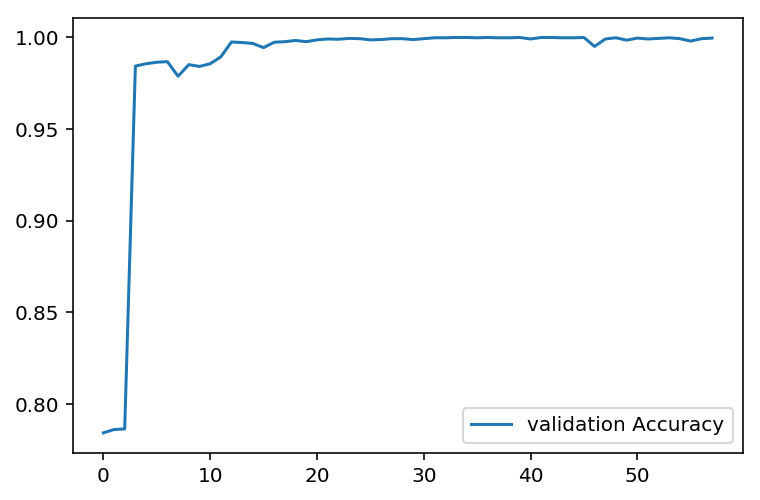

In [290]:
plt.plot(val_accuracy, label='validation Accuracy')
plt.legend()
_ = plt.ylim()

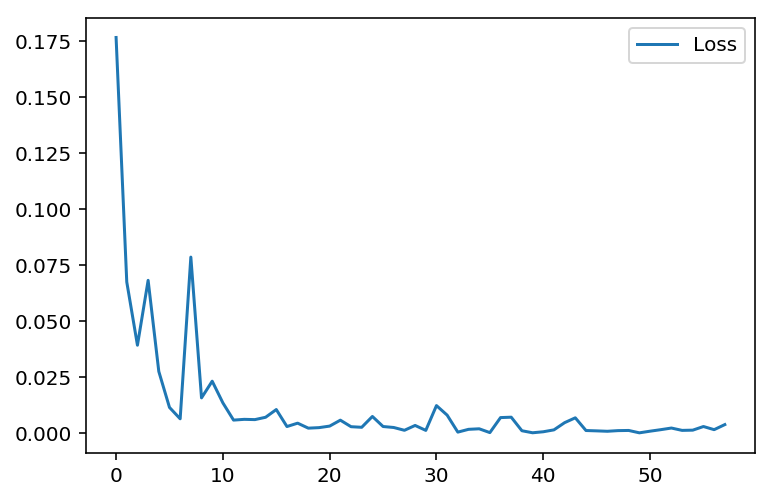

In [291]:
plt.plot(training_loss, label='Loss')
plt.legend()
_ = plt.ylim()

## Check out your predictions

Here, use the test data to view how well your network is modeling the data. If something is completely wrong here, make sure each step in your network is implemented correctly.

In [292]:
def get_tensors(loaded_graph):
    """
    Get input, initial state, final state, keep_prob, accurracy and predictions tensor from <loaded_graph>
    :param loaded_graph: TensorFlow graph loaded from file
    :return: Tuple (InputTensor, InitialStateTensor, FinalStateTensor, KeepProbTensor, AccurracyTensor, PredictionsTensor)
    """
    # TODO: Implement Function
    inputs = loaded_graph.get_tensor_by_name("inputs:0")
    targets = loaded_graph.get_tensor_by_name("targets:0")
    initial_state = loaded_graph.get_tensor_by_name("initial_state:0")
    final_state = loaded_graph.get_tensor_by_name("final_state:0")
    keep_prob = loaded_graph.get_tensor_by_name("keep_prob:0")
    accurracy = loaded_graph.get_tensor_by_name("accurracy:0")
    predictions = loaded_graph.get_tensor_by_name("predictions:0")
    learning_rate = loaded_graph.get_tensor_by_name("learning_rate:0")
    is_training = loaded_graph.get_tensor_by_name("is_training:0")
    return inputs, initial_state, final_state, targets, keep_prob, accurracy, predictions, learning_rate, is_training

In [293]:
def scale_data(input_data):
		m_time_delta, s_time_delta = scaled_features['time_delta']
		m_tickets, s_tickets = scaled_features['Tickets']
		m_csat, s_csat = scaled_features['csat']

		input_data[-3] = np.float32((input_data[-3] - m_time_delta) / s_time_delta)
		input_data[-2] = np.float32((input_data[-2] - m_tickets) / s_tickets)
		input_data[-1] = np.float32((input_data[-1] - m_csat) / s_csat)

		print("Scaling data")

		return input_data

### Create a graph to compare the data and predictions

In [299]:
test_acc = []
loaded_graph = tf.Graph()
with tf.Session(graph=loaded_graph) as sess:
    # Load saved model
    loader = tf.train.import_meta_graph(save_dir + '.meta')
    loader.restore(sess, save_dir)
    
    # Get Tensors from loaded model
    input_data, initial_state, final_state, targets, keep_prob, accurracy, predictions, learning_rate, is_training = get_tensors(loaded_graph)
    val_acc = []
    val_state = sess.run(initial_state)
    for x, y in get_batches(test_features, test_targets, batch_size,25):
        feed = {input_data: x,
                targets: y,
                keep_prob: 1,
                initial_state: val_state,
                learning_rate: learning_rate_val,
                is_training: False}
        batch_acc, val_state = sess.run([accurracy, final_state], feed_dict=feed)
        val_acc.append(batch_acc)
        

    print("Test accuracy: {:.3f}".format(np.mean(val_acc)))
    
    batch = get_batches(test_features, test_targets, 1, 50)
    x,y = next(batch)

    feed = {input_data: x,
                keep_prob: 1,
                initial_state: val_state,
                learning_rate: learning_rate_val,
                is_training: False
           }
    
    pred = sess.run([predictions], feed_dict=feed)

INFO:tensorflow:Restoring parameters from save/chkpnt_0
Test accuracy: 1.000


In [300]:
print(pred)

[array([[[ 1.],
        [ 1.],
        [ 0.],
        [ 1.],
        [ 0.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 0.],
        [ 0.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 0.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 0.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 0.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 0.],
        [ 0.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 0.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 0.],
        [ 1.],
        [ 1.],
        [ 1.],
        [ 0.],
        [ 1.],
        [ 1.]]], dtype=float32)]


In [301]:
print(y)

[[[1]
  [1]
  [0]
  [1]
  [0]
  [1]
  [1]
  [1]
  [1]
  [1]
  [0]
  [0]
  [1]
  [1]
  [1]
  [0]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [0]
  [1]
  [1]
  [1]
  [1]
  [0]
  [1]
  [1]
  [1]
  [0]
  [0]
  [1]
  [1]
  [1]
  [1]
  [1]
  [1]
  [0]
  [1]
  [1]
  [1]
  [0]
  [1]
  [1]
  [1]
  [0]
  [1]
  [1]]]
